### Import mujoco and numpy

In [1]:
import numpy as np
from numpy.linalg import inv, pinv
import jax.numpy as jnp
from jax import vmap
import scipy as sp

from utils import rot_err, getSitePose, getSiteJacobian, getMassMatrix, getBiasTerms, getOSMassMatrix
# from sim import Sim
from solver import AugmentedLagrangian
# sim = Sim(fname='./a1/xml/a1.xml')

import matplotlib.pyplot as plt

In [2]:
class HopperDynamics(object):
    def __init__(self, dt=0.1) -> None:
        self._m  = 1.0
        # self._I = np.diag([1.0, 1.0, 1.0])
        self._g  = 9.81 
        self._dt = dt

        def dfdt(x, u):
            p, pdot = x 
            f = u[0]
            pddot = f - self._g
            return jnp.array([pdot, pddot]) 
        def f(x, u):
            return x + self._dt * self.dfdt(x, u)
        
        self.dfdt = dfdt 
        self.f = f 

hopper_model = HopperDynamics()
def phi(x):
    return x[0]-0.5

In [3]:
def ineq_constr(x, args):
    q = x[:,:2]
    f = x[:,2:]
    _phi_out = vmap(phi)(q)
    return jnp.concatenate([-_phi_out, -f[:,0]])

def eq_constr(x, args):
    q = x[:,:2]
    f = x[:,2:]
    q0 = args['q0']
    qf = args['qf']
    _phi_out = vmap(phi)(q)
    return jnp.concatenate([
        (q[0] - q0).flatten(),
        (q[1:,:]-vmap(hopper_model.f)(q[:-1,:], f[:-1,:])).flatten(),
        (_phi_out*f[:,0]).flatten(),
        (q[-1] - qf).flatten()
    ])

In [4]:
args = {
    'q0' : np.array([5.,0.]),
    'qf' : np.array([10.,0.]) 
}

def loss(x, args):
    q, f = x[:,:2], x[:,2:]
    return jnp.array(0.)#jnp.mean(f**2)


In [5]:
time_horizon = int(6/hopper_model._dt)
# q = jnp.linspace(args['q0'], args['qf'], time_horizon, endpoint=True)
q = jnp.zeros((time_horizon, 2))
u = jnp.zeros((time_horizon, 1))
x = jnp.concatenate([q, u], axis=1)

In [6]:
opt_solver = AugmentedLagrangian(x, loss, eq_constr, ineq_constr, args=args, step_size=1e-3, c=1.0)

In [7]:
opt_solver.solve(eps=1e-5)

False

In [8]:
sol = opt_solver.get_solution()

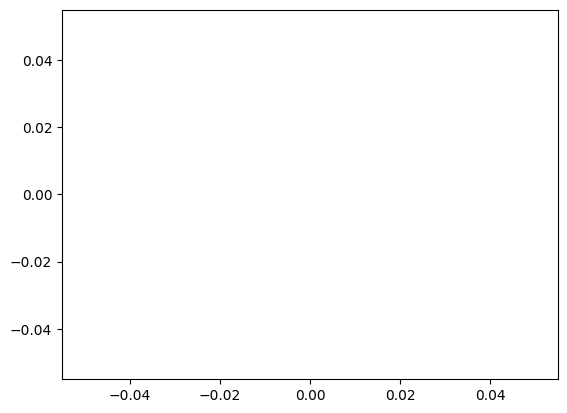

In [12]:
plt.plot(sol['x'][:,0])

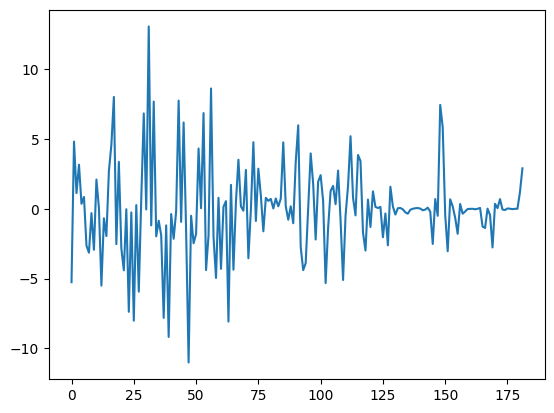

In [35]:
plt.plot(eq_constr(sol['x'], args))

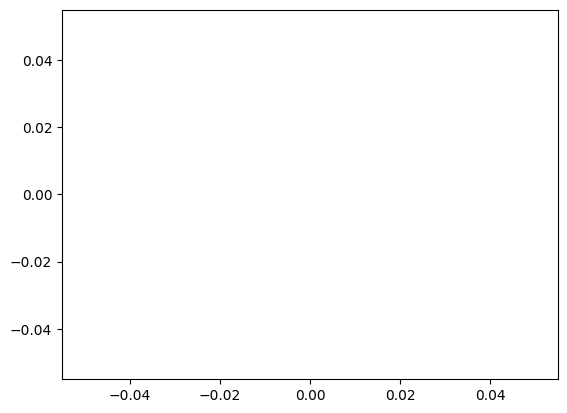

In [25]:
plt.plot(sol['x'])